In [128]:

import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("steel.csv")
df.head()


,normalising_temperature,tempering_temperature,percent_silicon,percent_chromium,percent_copper,percent_nickel,percent_sulphur,percent_carbon,percent_manganese,tensile_strength
0,178.500,275,0.1530,0.970575,0.942,0.8870,0.0,1.920,0.0,25.107613
1,178.500,950,0.1530,1.212726,0.942,0.8870,0.0,1.920,0.0,140.035334
2,178.500,375,0.1530,1.621165,0.942,0.8870,0.0,1.920,0.0,42.217650
3,178.500,900,0.1530,0.809989,0.942,0.8870,0.0,1.920,0.0,95.015309
4,189.525,900,0.1624,1.036229,0.849,0.9382,0.0,2.035,0.0,113.266773


In [129]:
# metrics to compare performance
#RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#MAPE
def mape(y_true, y_pred):
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

In [130]:
# Define features and target variable
target_col = 'tensile_strength'
X = df.drop(columns=[target_col])
y = df[target_col].values
feature_names = X.columns.tolist()
X = X.values
print("Features:", feature_names)

Features: ['normalising_temperature', 'tempering_temperature', 'percent_silicon', 'percent_chromium', 'percent_copper', 'percent_nickel', 'percent_sulphur', 'percent_carbon', 'percent_manganese']


In [131]:
# Experimental setup
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [132]:
# Default SVR with outer 10 fold cross validation
svr_default = SVR(C=1.0, kernel='rbf', gamma='scale')  

results_default = {
    'fold': [],
    'train_rmse': [],
    'test_rmse': [],
    'train_mape': [],
    'test_mape': [],
    'train_r2': [],
    'test_r2': []
}

fold_idx = 0
for train_idx, test_idx in outer_cv.split(X):
    fold_idx += 1
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Scaling
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # training default SVR
    svr_default.fit(X_train_s, y_train)

    # Predictions
    y_train_pred = svr_default.predict(X_train_s)
    y_test_pred = svr_default.predict(X_test_s)

    # Check RMSE, MAPE, R2
    results_default['fold'].append(fold_idx)
    results_default['train_rmse'].append(rmse(y_train, y_train_pred))
    results_default['test_rmse'].append(rmse(y_test, y_test_pred))
    results_default['train_mape'].append(mape(y_train, y_train_pred))
    results_default['test_mape'].append(mape(y_test, y_test_pred))
    results_default['train_r2'].append(r2_score(y_train, y_train_pred))
    results_default['test_r2'].append(r2_score(y_test, y_test_pred))

# Summary table
df_default = pd.DataFrame(results_default)
display(df_default)
print("\nDefault SVR - Average across folds:")
summary_default = df_default.drop(columns=['fold']).agg(['mean','std']).T
display(summary_default)

,fold,train_rmse,test_rmse,train_mape,test_mape,train_r2,test_r2
0,1,76.328871,101.418299,44.947179,78.302542,0.252894,0.185425
1,2,78.981366,74.870357,48.343460,45.052984,0.262760,0.171852
2,3,80.777002,62.847163,47.814834,38.608780,0.241611,0.281035
3,4,78.877596,86.260955,47.837549,39.437851,0.241547,0.163584
4,5,79.798833,76.171723,47.658149,37.619143,0.238325,0.241515
5,6,80.926929,61.590639,49.068556,35.238918,0.236802,0.314363
6,7,79.487703,73.643731,48.527779,40.974520,0.249075,0.236619
7,8,80.413283,68.631096,47.478756,50.903347,0.232169,0.314631
8,9,76.512323,104.144396,45.279575,68.787752,0.241679,0.177647
9,10,79.577427,76.668686,47.703201,46.558438,0.239866,0.257688



Default SVR - Average across folds:


,mean,std
train_rmse,79.168133,1.603250
test_rmse,78.624704,14.593856
train_mape,47.465904,1.330977
test_mape,48.148427,14.340374
train_r2,0.243673,0.008906
test_r2,0.234436,0.057880


In [133]:
# tuned SVR with C and Gamma hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1, 10]
}
# inner cross validation for grid search
inner_cv_folds = 5

results_tuned = {
    'fold': [],
    'best_params': [],
    'train_rmse': [],
    'test_rmse': [],
    'train_mape': [],
    'test_mape': [],
    'train_r2': [],
    'test_r2': []
}

fold_idx = 0
for train_idx, test_idx in outer_cv.split(X):
    fold_idx += 1
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Scaling
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # Grid search on training fold (inner CV)
    base_svr = SVR(kernel='rbf')
    gs = GridSearchCV(
        estimator=base_svr,
        param_grid=param_grid,
        cv=inner_cv_folds,
        scoring='neg_mean_squared_error',
        n_jobs=1,
        refit=True
    )
    gs.fit(X_train_s, y_train)

    best = gs.best_estimator_
    best_params = gs.best_params_

    # predictions on training and outer test fold
    y_train_pred = best.predict(X_train_s)
    y_test_pred = best.predict(X_test_s)

    results_tuned['fold'].append(fold_idx)
    results_tuned['best_params'].append(best_params)
    results_tuned['train_rmse'].append(rmse(y_train, y_train_pred))
    results_tuned['test_rmse'].append(rmse(y_test, y_test_pred))
    results_tuned['train_mape'].append(mape(y_train, y_train_pred))
    results_tuned['test_mape'].append(mape(y_test, y_test_pred))
    results_tuned['train_r2'].append(r2_score(y_train, y_train_pred))
    results_tuned['test_r2'].append(r2_score(y_test, y_test_pred))

# Summary table
df_tuned = pd.DataFrame(results_tuned)
display(df_tuned)

print("\nTuned SVR - Average across folds:")
summary_tuned = df_tuned.drop(columns=['fold','best_params']).agg(['mean','std']).T
display(summary_tuned)

from collections import Counter
print("\nBest params frequency across folds:")
Counter(tuple(sorted(d.items())) for d in df_tuned['best_params'])

,fold,best_params,train_rmse,test_rmse,train_mape,test_mape,train_r2,test_r2
0,1,"{'C': 100, 'gamma': 0.01}",38.597442,45.189634,17.951403,23.133634,0.808961,0.838275
1,2,"{'C': 100, 'gamma': 0.01}",38.641490,43.698070,17.958091,22.135044,0.823531,0.717894
2,3,"{'C': 100, 'gamma': 0.01}",38.933217,40.120311,18.203938,18.478685,0.823820,0.707002
3,4,"{'C': 100, 'gamma': 0.01}",38.420939,44.490323,17.996442,20.215700,0.820048,0.777503
4,5,"{'C': 100, 'gamma': 0.01}",39.298855,36.435441,18.402438,16.067182,0.815271,0.826457
5,6,"{'C': 100, 'gamma': 0.01}",39.489088,32.998355,18.316413,15.748633,0.818279,0.803189
6,7,"{'C': 100, 'gamma': 0.01}",38.296448,44.841319,17.705616,24.117759,0.825694,0.716974
7,8,"{'C': 100, 'gamma': 0.01}",39.375982,34.043059,18.263062,19.357952,0.815892,0.831368
8,9,"{'C': 100, 'gamma': 0.01}",38.812324,41.458474,18.477691,15.401030,0.804867,0.869679
9,10,"{'C': 100, 'gamma': 0.01}",39.290536,38.160120,18.309764,17.852998,0.814695,0.816105



Tuned SVR - Average across folds:


,mean,std
train_rmse,38.915632,0.427353
test_rmse,40.143511,4.555149
train_mape,18.158486,0.244182
test_mape,19.250862,3.123324
train_r2,0.817106,0.006641
test_r2,0.790445,0.057879



Best params frequency across folds:


Counter({(('C', 100), ('gamma', 0.01)): 10})

In [134]:
# compare tuned vs untuned summary
summary_rows = []

def agg_stats(df_metrics, label):
    cols_to_drop = ['fold']
    if 'best_params' in df_metrics.columns:
        cols_to_drop.append('best_params')
    numeric_df = df_metrics.drop(columns=cols_to_drop)
    mean_vals = numeric_df.agg('mean')
    std_vals = numeric_df.agg('std')
    return {
        'model': label,
        'train_rmse_mean': mean_vals.get('train_rmse', float('nan')) ,
        'train_rmse_std': std_vals.get('train_rmse', float('nan')) ,
        'test_rmse_mean': mean_vals.get('test_rmse', float('nan')) ,
        'test_rmse_std': std_vals.get('test_rmse', float('nan')) ,
        'train_mape_mean': mean_vals.get('train_mape', float('nan')) ,
        'train_mape_std': std_vals.get('train_mape', float('nan')) ,
        'test_mape_mean': mean_vals.get('test_mape', float('nan')) ,
        'test_mape_std': std_vals.get('test_mape', float('nan')) ,
        'train_r2_mean': mean_vals.get('train_r2', float('nan')) ,
        'test_r2_mean': mean_vals.get('test_r2', float('nan'))
    }

summary_rows.append(agg_stats(df_default, 'SVR_default'))
summary_rows.append(agg_stats(df_tuned, 'SVR_tuned'))

df_summary = pd.DataFrame(summary_rows)
display(df_summary)


,model,train_rmse_mean,train_rmse_std,test_rmse_mean,test_rmse_std,train_mape_mean,train_mape_std,test_mape_mean,test_mape_std,train_r2_mean,test_r2_mean
0,SVR_default,79.168133,1.603250,78.624704,14.593856,47.465904,1.330977,48.148427,14.340374,0.243673,0.234436
1,SVR_tuned,38.915632,0.427353,40.143511,4.555149,18.158486,0.244182,19.250862,3.123324,0.817106,0.790445


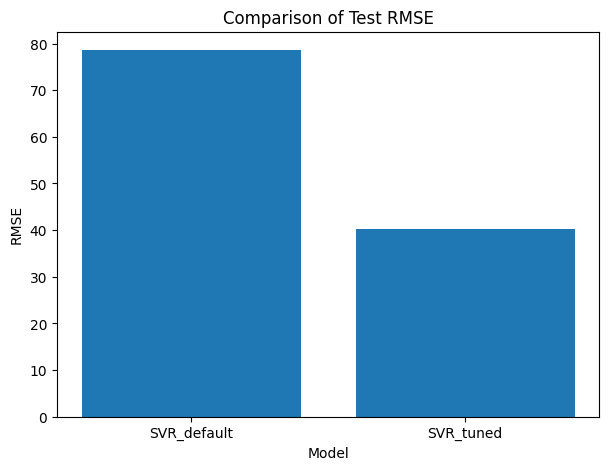

In [135]:
# Charts

plt.figure(figsize=(7,5))
plt.bar(
    df_summary['model'],
    df_summary['test_rmse_mean']
)
plt.title("Comparison of Test RMSE")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.show()


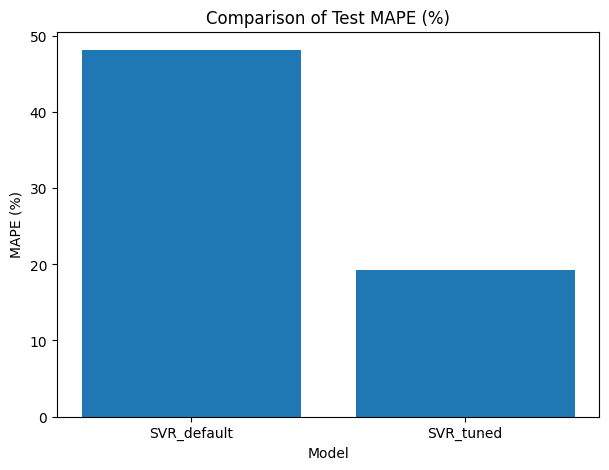

In [136]:
#MAPE chart
plt.figure(figsize=(7,5))
plt.bar(
    df_summary['model'],
    df_summary['test_mape_mean']
)
plt.title("Comparison of Test MAPE (%)")
plt.ylabel("MAPE (%)")
plt.xlabel("Model")
plt.show()


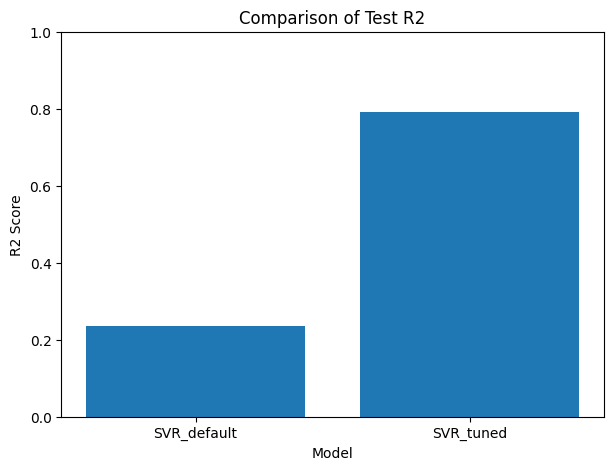

In [137]:
#R2 chart
plt.figure(figsize=(7,5))
plt.bar(
    df_summary['model'],
    df_summary['test_r2_mean']
)
plt.title("Comparison of Test R2")
plt.ylabel("R2 Score")
plt.xlabel("Model")
plt.ylim(0, 1) 
plt.show()



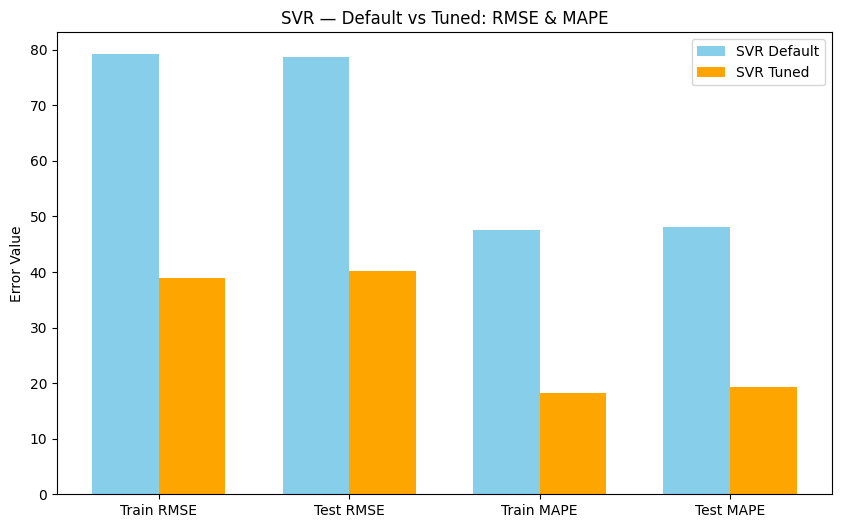

In [ ]:
# chart labels
labels = ['Train RMSE', 'Test RMSE', 'Train MAPE', 'Test MAPE']
svr_default_vals = [
    df_default['train_rmse'].mean(),
    df_default['test_rmse'].mean(),
    df_default['train_mape'].mean(),
    df_default['test_mape'].mean()
]
svr_tuned_vals = [
    df_tuned['train_rmse'].mean(),
    df_tuned['test_rmse'].mean(),
    df_tuned['train_mape'].mean(),
    df_tuned['test_mape'].mean()
]
# ordering of bars
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, svr_default_vals, width, label='SVR Default', color='skyblue')
plt.bar(x + width/2, svr_tuned_vals, width, label='SVR Tuned', color='orange')
plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("SVR — Default vs Tuned: RMSE & MAPE")
plt.legend()
plt.show()